In [1]:
using Pkg  # activa los paquetes para instalarlos con el comado !using dentro del notebook
const DIR = @__DIR__ # Activa el directorio donde guarda el dataset
Pkg.activate(DIR) # Guarada por defecto el archivo
Pkg.instantiate()

  Activating project at `/home/matasietephi/Documentos/jupyterNOTEBOOK`


In [2]:
using MLJ  #PAquete Machine Lerning Julia
using Flux # ML Multipropósito JULIA
import MLJFlux 
import MLJIteration # Iterqación de Tensores y pilas de compilación
import MLDatasets: FashionMNIST  #dataset 

MLJ.color_off() #Al ser el dataset una escala de grises se deja sin efecto RGB

using Plots  #Gráficos
pyplot(size=(600, 300*(sqrt(5)-1)));  # Tamaño delos gráficos a mostrar

In [3]:
ENV["DATADEPS_ALWAYS_ACCEPT"] = true   #Almacenamiento del Data set
images, labels = FashionMNIST.traindata(); #División del dataset de entrenamiento

In [4]:
labels = coerce(labels, Multiclass); # División en multiclases del dataset con etiquetas
images = coerce(images, GrayImage); # Imagen en escala de grises

In [5]:
@assert scitype(images) <: AbstractVector{<:Image}  #Guarda en un array float 64
@assert scitype(labels) <: AbstractVector{<:Finite}

In [6]:
#Muestra la imagen que es el input del autoencoder
images[1]

In [7]:
struct Convolucion
    filter_size::Int
    channels1::Int
    channels2::Int
    channels3::Int
end

make2d(x::AbstractArray) = reshape(x, :, size(x)[end])

function MLJFlux.build(b::Convolucion, rng, n_in, n_out, n_channels)
    k, c1, c2, c3 = b.filter_size, b.channels1, b.channels2, b.channels3
    mod(k, 2) == 1 || error("`filter_size` must be odd. ")
    p = div(k - 1, 2) # padding en el tamaño de la imagen de entrada
    init = Flux.glorot_uniform(rng)
    front = Chain(
        Conv((k, k), n_channels => c1, pad=(p, p), relu, init=init), #Capa convolucional, activación:relu
        MaxPool((2, 2)),                                             # Capa Maxpool
        Conv((k, k), c1 => c2, pad=(p, p), relu, init=init),         #Capa Covolucional, activación:relu
        MaxPool((2, 2)),                                             # Capa Maxpool 
        Conv((k, k), c2 => c3, pad=(p, p), relu, init=init),         # Capa Convolucional, activación:relu
        MaxPool((2 ,2)),
        make2d)
    d = Flux.outputsize(front, (n_in..., n_channels, 1)) |> first
    return Chain(front, Dense(d, n_out, init=init))
end

In [8]:
ImageClassifier = @load ImageClassifier
clf = ImageClassifier(builder=Convolucion(3, 16, 32, 32), #canales y capas de "Paso"
                      batch_size=50,  # División del dataset en bach
                      epochs=10,      # epocas
                      rng=123)        # rango 

import MLJFlux ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /root/.julia/packages/MLJModels/OYpZv/src/loading.jl:168


ImageClassifier(
    builder = Convolucion(3, 16, 32, 32),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}()),
    loss = Flux.Losses.crossentropy,
    epochs = 10,
    batch_size = 50,
    lambda = 0.0,
    alpha = 0.0,
    rng = 123,
    optimiser_changes_trigger_retraining = false,
    acceleration = CPU1{Nothing}(nothing))

In [9]:
#Verificación del clasificador
listo = machine(clf, images, labels);


In [10]:
# Entrenamiento del modelo
fit!(listo, rows=1:500, verbosity=2);


┌ Info: Training Machine{ImageClassifier{Convolucion,…},…}.
└ @ MLJBase /root/.julia/packages/MLJBase/rMXo2/src/machines.jl:423
┌ Info: Loss is 2.271
└ @ MLJFlux /root/.julia/packages/MLJFlux/ex3rh/src/core.jl:127
┌ Info: Loss is 2.145
└ @ MLJFlux /root/.julia/packages/MLJFlux/ex3rh/src/core.jl:127
┌ Info: Loss is 1.87
└ @ MLJFlux /root/.julia/packages/MLJFlux/ex3rh/src/core.jl:127
┌ Info: Loss is 1.409
└ @ MLJFlux /root/.julia/packages/MLJFlux/ex3rh/src/core.jl:127
┌ Info: Loss is 1.077
└ @ MLJFlux /root/.julia/packages/MLJFlux/ex3rh/src/core.jl:127
┌ Info: Loss is 0.9655
└ @ MLJFlux /root/.julia/packages/MLJFlux/ex3rh/src/core.jl:127
┌ Info: Loss is 0.8887
└ @ MLJFlux /root/.julia/packages/MLJFlux/ex3rh/src/core.jl:127
┌ Info: Loss is 0.8266
└ @ MLJFlux /root/.julia/packages/MLJFlux/ex3rh/src/core.jl:127
┌ Info: Loss is 0.78
└ @ MLJFlux /root/.julia/packages/MLJFlux/ex3rh/src/core.jl:127
┌ Info: Loss is 0.7389
└ @ MLJFlux /root/.julia/packages/MLJFlux/ex3rh/src/core.jl:127


In [11]:
# Report es similar a la función de salida de cada canal (prueba)
report(listo)

(training_losses = Float32[2.3048406, 2.2705374, 2.145361, 1.869585, 1.4091722, 1.0768585, 0.9654652, 0.8887436, 0.82655656, 0.7799691, 0.7388741],)

In [12]:
# Equivalente a la imprimir la estructura del autoencoder en Pytorch
chain = fitted_params(listo)
summary(chain)

"NamedTuple{(:chain,), Tuple{Chain{Tuple{Chain{Tuple{Chain{Tuple{Conv{2, 2, typeof(relu), Array{Float32, 4}, Vector{Float32}}, MaxPool{2, 4}, Conv{2, 2, typeof(relu), Array{Float32, 4}, Vector{Float32}}, MaxPool{2, 4}, Conv{2, 2, typeof(relu), Array{Float32, 4}, Vector{Float32}}, MaxPool{2, 4}, typeof(make2d)}}, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}}}, typeof(softmax)}}}}"

In [13]:
# Valor de salida que pasa por el autoencoder (chain) y los valores obtenidos a la salida 
Flux.params(chain)[2]


16-element Vector{Float32}:
  0.016646365
  0.070121676
 -0.0019039176
  0.03424927
  7.7404606f-5
  0.028425027
  0.022402812
 -0.0009378204
  0.06197482
  0.02234768
  0.0014841413
  0.052730635
  0.018775292
  0.024079103
  0.022954524
  0.019735822

In [14]:
# Ahora comienza lo bueno!!!
# Entrenamiento del modelo al menos 10 épocas
clf.epochs = clf.epochs + 50
fit!(listo, rows=1:500);

┌ Info: Updating Machine{ImageClassifier{Convolucion,…},…}.
└ @ MLJBase /root/.julia/packages/MLJBase/rMXo2/src/machines.jl:424
Optimising neural net: 100%[=========================] Time: 0:00:30


In [15]:
# Predicción del modelo después de 20 épcas 
predicted_labels = predict(listo, rows=501:1000);
cross_entropy(predicted_labels, labels[501:1000]) |> mean  # Tipo de optimizador Cross Entropy Loss


0.6041809f0

In [16]:
# Evaluación del Modelo
evaluate!(listo,
          resampling=Holdout(fraction_train=0.5),
          measure=cross_entropy, # Optimizador Cross Entropy Loss
          rows=1:1000, 
          verbosity=0)

PerformanceEvaluation object with these fields:
  measure, measurement, operation, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_pairs
Extract:
┌────────────────────────────┬─────────────┬───────────┬────────────────┐
│ measure                    │ measurement │ operation │ per_fold       │
├────────────────────────────┼─────────────┼───────────┼────────────────┤
│ LogLoss(tol = 2.22045e-16) │ 0.604       │ predict   │ Float32[0.604] │
└────────────────────────────┴─────────────┴───────────┴────────────────┘


Ahora se realizará el análisis de un autoencoder convolucional con JULIA, el anterior caso es un clasificador convolucional

# Autoencoder Convolucional - Machine Learning

In [17]:
make2d(x::AbstractArray) = reshape(x, :, size(x)[end])
make1d(x::AbstractArray) = reshape(x, length(x));

In [18]:
parameters(listo) = make1d.(Flux.params(fitted_params(listo)));


In [19]:
losses = [] # Pérdida-----> Gráfico 
training_losses = [] # Entrenamiento y pérdida ---> Gráfico
parameter_means = Float32[]; # parámetros de etiqueta ------> Gráfico 
epochs = [] # épocas -----> Gráfico

Any[]

In [20]:
# Definición delos parámetros
act_loss(loss) = push!(losses, loss)
act_training_loss(losses) = push!(training_losses, losses[end])
act_means(listo) = append!(parameter_means, mean.(parameters(listo)));
act_epochs(epoch) = push!(epochs, epoch)

act_epochs (generic function with 1 method)

In [21]:

guarda_control = MLJIteration.skip(Save(joinpath(DIR, "fashionmnist.jlso")), predicate=3) #Guarda los datos del entrenamiento

controls=[Step(2),
          Patience(3),
          InvalidValue(),
          TimeLimit(5/60),
          guarda_control,
          WithLossDo(),
          WithLossDo(act_loss),
          WithTrainingLossesDo(act_training_loss),
          Callback(act_means),
          WithIterationsDo(act_epochs)
];

In [22]:
iteracion_clf = IteratedModel(model=clf,
                       controls=controls,
                       resampling=Holdout(fraction_train=0.7),
                       measure=log_loss)

ProbabilisticIteratedModel(
    model = ImageClassifier(
            builder = Convolucion(3, 16, 32, 32),
            finaliser = NNlib.softmax,
            optimiser = ADAM(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}()),
            loss = Flux.Losses.crossentropy,
            epochs = 60,
            batch_size = 50,
            lambda = 0.0,
            alpha = 0.0,
            rng = 123,
            optimiser_changes_trigger_retraining = false,
            acceleration = CPU1{Nothing}(nothing)),
    controls = Any[Step(2), Patience(3), InvalidValue(), TimeLimit(Dates.Millisecond(300000)), IterationControl.Skip{Save{typeof(Serialization.serialize)}, IterationControl.var"#8#9"{Int64}}(Save{typeof(Serialization.serialize)}("/home/matasietephi/Documentos/jupyterNOTEBOOK/fashionmnist.jlso", Serialization.serialize), IterationControl.var"#8#9"{Int64}(3)), WithLossDo{IterationControl.var"#20#22"}(IterationControl.var"#20#22"(), false, nothing), WithLossDo{typeof(act_loss)}(act_loss, fa

In [23]:
listo = machine(iteracion_clf, images, labels);


In [24]:
#Entrenamiento del modelo
fit!(listo, rows=50:6000);  # Marca el bach y el set de entrenamiento en una linea (50:6000)


┌ Info: Training Machine{ProbabilisticIteratedModel{ImageClassifier{Convolucion,…}},…}.
└ @ MLJBase /root/.julia/packages/MLJBase/rMXo2/src/machines.jl:423
┌ Info: No iteration parameter specified. Using `iteration_parameter=:(epochs)`. 
└ @ MLJIteration /root/.julia/packages/MLJIteration/J0pbp/src/core.jl:62
┌ Info: loss: 0.7210477
└ @ IterationControl /root/.julia/packages/IterationControl/wJWPx/src/controls.jl:278
┌ Info: loss: 0.59739786
└ @ IterationControl /root/.julia/packages/IterationControl/wJWPx/src/controls.jl:278
┌ Info: Saving "/home/matasietephi/Documentos/jupyterNOTEBOOK/fashionmnist1.jlso". 
└ @ MLJIteration /root/.julia/packages/MLJIteration/J0pbp/src/controls.jl:203
┌ Info: loss: 0.5437505
└ @ IterationControl /root/.julia/packages/IterationControl/wJWPx/src/controls.jl:278
┌ Info: loss: 0.49457017
└ @ IterationControl /root/.julia/packages/IterationControl/wJWPx/src/controls.jl:278
┌ Info: loss: 0.4695177
└ @ IterationControl /root/.julia/packages/IterationControl/w

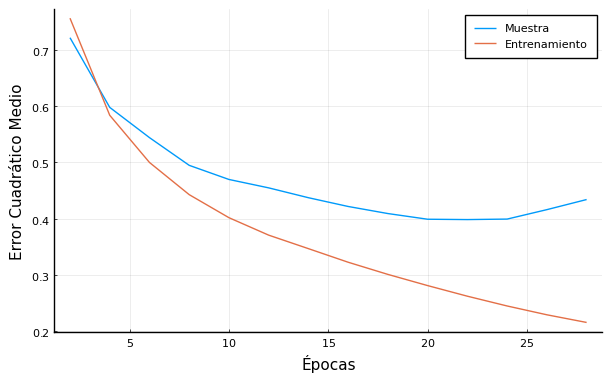

In [25]:
# Gráfico de entrenamiento y pérdida
plot(epochs, losses,
     xlab = "Épocas",
     ylab = "Error Cuadrático Medio",
     label="Muestra")
plot!(epochs, training_losses, label="Entrenamiento")

savefig(joinpath(DIR, "Perdida.png")) #Guarda la imagen en el directorio asignado

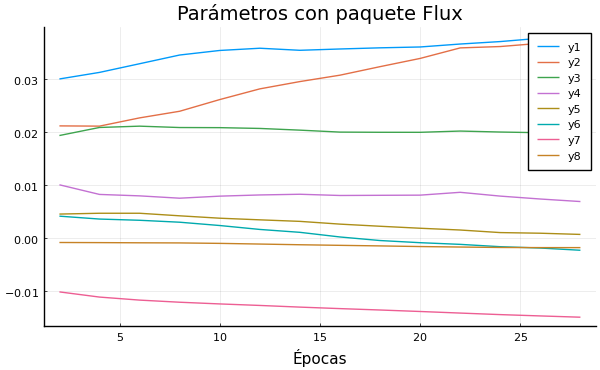

In [26]:
# Entrenamiento para los distintos canales

n_epochs =  length(losses)
n_parameters = div(length(parameter_means), n_epochs)
parameter_means2 = reshape(copy(parameter_means), n_parameters, n_epochs)'
plot(epochs, parameter_means2,
     title="Parámetros con paquete Flux",
     xlab = "Épocas")

In [27]:
savefig(joinpath(DIR, "pesos.png")) # Guarda los pesos


In [28]:
# Verificación de las etiquetas guardadas

mach2 = machine(joinpath(DIR, "fashionmnist3.jlso"))
predict_mode(mach2, images[501:503])

3-element CategoricalArrays.CategoricalArray{Int64,1,UInt32}:
 4
 6
 4

┌ Info: Training Machine{ProbabilisticIteratedModel{ImageClassifier{Convolucion,…}},…}.
└ @ MLJBase /root/.julia/packages/MLJBase/rMXo2/src/machines.jl:423
┌ Info: No iteration parameter specified. Using `iteration_parameter=:(epochs)`. 
└ @ MLJIteration /root/.julia/packages/MLJIteration/J0pbp/src/core.jl:62
┌ Info: loss: 2.1704955
└ @ IterationControl /root/.julia/packages/IterationControl/wJWPx/src/controls.jl:278
┌ Info: loss: 1.7277346
└ @ IterationControl /root/.julia/packages/IterationControl/wJWPx/src/controls.jl:278
┌ Info: Saving "/home/matasietephi/Documentos/jupyterNOTEBOOK/fashionmnist1.jlso". 
└ @ MLJIteration /root/.julia/packages/MLJIteration/J0pbp/src/controls.jl:203
┌ Info: loss: 1.057634
└ @ IterationControl /root/.julia/packages/IterationControl/wJWPx/src/controls.jl:278
┌ Info: loss: 0.79384065
└ @ IterationControl /root/.julia/packages/IterationControl/wJWPx/src/controls.jl:278
┌ Info: loss: 0.7062432
└ @ IterationControl /root/.julia/packages/IterationControl/wJW

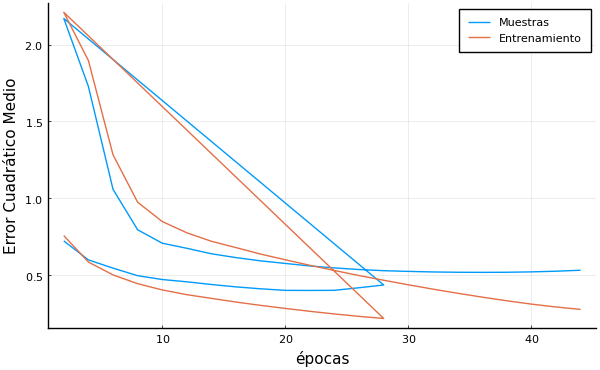

In [29]:

iteracion_clf.controls[2] = Patience(4)
fit!(listo, rows=1:500)

plot(epochs, losses,
     xlab = "épocas",
     ylab = "Error Cuadrático Medio",
     label="Muestras")
plot!(epochs, training_losses, label="Entrenamiento")